# 基于集成学习的 Amazon 用户评论质量预测
---
## 一.案例介绍
随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。  
在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。  
因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。  
本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

In [70]:
import pandas as pd
import numpy as np

## 二.数据概览
***Amazon*** **用户评论质量**
* ***reviewerID*** 用户ID 👽
* ***asin*** 商品ID 👔
* ***reviewText*** 评论 💬
* ***overall*** 商品评分 💯
* ***votes_up*** 评论点赞数 💚
* ***votes_all*** 评论总评价数 🗳️
* ***label*** 评论质量 ✔️❌

[📢] 注：
1. 商品评分 ***1-5*** 分
2. 测试集中没有评论点赞数 *votes_up* 和评论总评价数 *votes_all* 
3. 评论质量 *label* 根据其他用户对评论的 *votes*，`votes_up/votes_all ≥ 0.9` 的作为高质量评论  
   ***1*** 表示高质量，***0*** 表示低质量
4. 此外测试集包含一个额外的列 *Id*，标识了每一个测试的样例。

##### 🔰导入数据
- **训练集**："./data/" 📂路径下 *train.csv* 📝文件  
  包含总共 ***57039*** 条数据样本💾  
  每条样本包含 ***7*** 个特征🐞：  
  - *reviewerID，asin，reviewText，overall，votes_up，votes_all，label*
- **测试集**："./data/" 📂路径下 *test.csv* 📝文件  
  包含总共 ***11208*** 条数据样本💾  
  每条样本包含 ***5*** 个特征🐞：  
  - *Id，reviewerID，asin，reviewText，overall*  
  
  **测试集标签**："./data/" 📂路径下 *groundTruth.csv* 📝文件  
  - *Id，Expected*

[📢]：测试集标签分离文件存储，*Id* 与测试集特征样本一一对应，*Expected* 即 *label*。

✔️⚙️借助 ***pandas*** 读入标准 *csv* 格式文件的函数 `read_csv()` 将数据转换为 `DataFrame` 的形式。

In [71]:
train_df = pd.read_csv('./data/train.csv', sep='\t')
test_df = pd.read_csv('./data/test.csv',sep='\t')
testlabels_df = pd.read_csv('./data/groundTruth.csv')

##### 🚂**训练集** 数据概览👓

In [72]:
# 显示训练集前三条数据
train_df.head(3) 

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1


In [73]:
# 显示训练集数据基本信息
# 可检查是否有数据丢失
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57039 entries, 0 to 57038
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewerID  57039 non-null  int64  
 1   asin        57039 non-null  int64  
 2   reviewText  57039 non-null  object 
 3   overall     57039 non-null  float64
 4   votes_up    57039 non-null  int64  
 5   votes_all   57039 non-null  int64  
 6   label       57039 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 3.0+ MB


In [74]:
# 显示训练集数据统计摘要
train_df.describe()

,reviewerID,asin,overall,votes_up,votes_all,label
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,33359.761865,19973.170866,3.535178,12.387594,18.475850,0.226196
std,30016.804127,14104.410152,1.529742,45.130499,50.149683,0.418371
min,50.000000,0.000000,1.000000,0.000000,5.000000,0.000000
25%,9235.000000,8218.000000,2.000000,4.000000,6.000000,0.000000
50%,22589.000000,17635.000000,4.000000,6.000000,10.000000,0.000000
75%,53170.000000,30875.000000,5.000000,11.000000,18.000000,0.000000
max,123767.000000,50051.000000,5.000000,6084.000000,6510.000000,1.000000


##### 🧪**测试集** 数据概览👓

In [75]:
# 显示测试集前三条数据
test_df.head(3)

,Id,reviewerID,asin,reviewText,overall
0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1.0
1,1,10154,23543,I have to say that this is a work of art for m...,4.0
2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3.0


In [76]:
# 显示测试集数据基本信息
# 可检查是否有数据丢失
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11208 entries, 0 to 11207
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          11208 non-null  int64  
 1   reviewerID  11208 non-null  int64  
 2   asin        11208 non-null  int64  
 3   reviewText  11208 non-null  object 
 4   overall     11208 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 437.9+ KB


In [77]:
# 显示测试集数据统计摘要
test_df.describe()

,Id,reviewerID,asin,overall
count,11208.000000,11208.000000,11208.000000,11208.000000
mean,5603.500000,31902.047198,18843.985724,3.499732
std,3235.615243,28901.767103,13937.632416,1.553254
min,0.000000,50.000000,5.000000,1.000000
25%,2801.750000,9081.500000,7131.000000,2.000000
50%,5603.500000,21528.000000,15400.000000,4.000000
75%,8405.250000,49195.000000,29175.250000,5.000000
max,11207.000000,122577.000000,50051.000000,5.000000


In [78]:
# 显示测试集前10条样本标签
testlabels_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Id,0,1,2,3,4,5,6,7,8,9
Expected,0,0,0,0,0,0,0,1,1,0


## 三.特征工程 + 实验方案
#### 🧰***sklearn*** 文本向量化工具  
- [***sklearn.feature_extraction.text.CountVectorizer***](https://github.com/xfkcode/MachineLearning/blob/main/python%E5%B7%A5%E5%85%B7/sklearn/sklearn%E5%AD%A6%E4%B9%A0%E7%AC%94%E8%AE%B01.ipynb)  
  将文本文档集合转换为计数矩阵。
- [***sklearn.feature_extraction.text.TfidfVectorizer***](https://github.com/xfkcode/MachineLearning/blob/main/python%E5%B7%A5%E5%85%B7/sklearn/sklearn%E5%AD%A6%E4%B9%A0%E7%AC%94%E8%AE%B02.ipynb)  
  将文档集合转换为TF-IDF功能矩阵。

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#### ***Test-1***
数据🧫
- 使用训练集前 ***2000*** 条数据作为 *Test-1* 全部数据进行数据划分测试  

⚠️电脑跑不动大规模数据❗❗❗

[📢]：训练集和测试集共同构建词表实现文本向量化

1. ***reviewText*** 评论文本向量化  
   - **全部数据** 构建词表，实现文本向量化
2. 数据划分✂️   
   训练集 : 测试集 ***(8:2)***

In [80]:
vectorizer1 = TfidfVectorizer(max_df=0.9, min_df=10)
vectorizer1.fit(train_df.reviewText[0:2000])
vectorizer1.get_feature_names_out()[:21:1]

array(['00', '000', '10', '100', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '1930', '1960', '1960s', '1962', '1969', '1970',
       '1972', '1974'], dtype=object)

In [81]:
X1 = vectorizer1.fit_transform(train_df.reviewText[0:2000])
print(X1.toarray()[0])
print(X1.shape)

[0. 0. 0. ... 0. 0. 0.]
(1000, 2153)


In [82]:
data1 = X1.toarray()
labels1 = np.array(train_df.label[0:2000])
data1.shape,labels1.shape

((1000, 2153), (1000,))

In [83]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data1, labels1, test_size=0.2, random_state=5315)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((800, 2153), (200, 2153), (800,), (200,))

#### ***Test-2***
数据🧫 
- 使用训练集前 ***2000*** 条数据作为 *Test-2* 训练集数据  
- 使用测试集前 ***200*** 条数据作为 *Test-2* 测试集数据  
 
⚠️电脑跑不动大规模数据❗❗❗

[📢]：仅使用训练集构建词表实现文本向量化

1. ***reviewText*** 评论文本向量化  
   - **训练集数据** 构建词表，实现文本向量化
2. 构建训练集、测试集数据

In [84]:
X2 = vectorizer1.transform(test_df.reviewText[0:200])
print(X2.toarray()[0])
print(X2.shape)

[0. 0. 0. ... 0. 0. 0.]
(200, 2153)


In [85]:
# 训练集
data2_train = X1.toarray()
labels2_train = np.array(train_df.label[0:2000])
# 测试集
data2_test = X2.toarray()
labels2_test = np.array(testlabels_df.Expected[0:200])
data2_train.shape, data2_test.shape, labels2_train.shape, labels2_test.shape

((1000, 2153), (200, 2153), (2000,), (200,))

## 四.模型构建
* Bagging + SVM
* Bagging + 决策树
* AdaBoost + SVM
* AdaBoost + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树


### 🧰***sklearn*** 实现
- 基分类器SVM： `SVC(C=200,kernel='rbf')`
- 基分类器DT：  &emsp;`DecisionTreeClassifier(max_depth=3)`

#### ***sklearn.ensemble.BaggingClassifier***🛍️
```python
class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, 
bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
```

#### ***sklearn.ensemble.AdaBoostClassifier***🥾
```python
class sklearn.ensemble.AdaBoostClassifier(base_estimator=None, *, n_estimators=50, 
learning_rate=1.0, algorithm='SAMME.R', random_state=None)
```

#### ***sklearn.tree.DecisionTreeClassifier***🌳
```python
class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
```

#### ***sklearn.svm.SVC***🚀
```python
class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, 
tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
```

In [86]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [87]:
# 存储sklearn-models预测结果
predictions=[] # model.predict()
y_score=[] # model.decision_function()
proba=[] # model.predict_proba()

#### ***Bagging + SVM***

In [88]:
Bagging_svm = BaggingClassifier(SVC(C=200,kernel='rbf'), n_estimators = 50)
Bagging_svm.fit(x_train,y_train)
predictions_Bs = Bagging_svm.predict(x_test)
predictions.append(predictions_Bs)
y_score_Bs = Bagging_svm.decision_function(x_test)
y_score.append(y_score_Bs)
proba_Bs = Bagging_svm.predict_proba(x_test)
proba.append(proba_Bs)

#### ***Bagging + DecisionTree***

In [89]:
Bagging_Dt = BaggingClassifier(DecisionTreeClassifier(max_depth=3), n_estimators = 50)
Bagging_Dt.fit(x_train,y_train)
predictions_BDT = Bagging_Dt.predict(x_test)
predictions.append(predictions_BDT)
# y_score_BDT = Bagging_Dt.decision_function(x_test) 报错？？？
# y_score.append(y_score_BDT)
proba_BDT = Bagging_Dt.predict_proba(x_test)
proba.append(proba_BDT)

#### ***AdaBoost + SVM***

In [90]:
adBt_svm = AdaBoostClassifier(SVC(C=200,kernel='rbf'), algorithm='SAMME', n_estimators = 10)
adBt_svm.fit(x_train,y_train)
predictions_adBtsvm = adBt_svm.predict(x_test)
predictions.append(predictions_adBtsvm)
y_score_adBtsvm = adBt_svm.decision_function(x_test)
y_score.append(y_score_adBtsvm)
proba_adBtsvm = adBt_svm.predict_proba(x_test)
proba.append(proba_adBtsvm)

#### ***AdaBoost + DecisionTree***

In [91]:
adBt_DT = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), algorithm='SAMME', n_estimators = 10)
adBt_DT.fit(x_train,y_train)
predictions_adBtDT = adBt_DT.predict(x_test)
predictions.append(predictions_adBtDT)
y_score_adBtDT = adBt_DT.decision_function(x_test)
y_score.append(y_score_adBtDT)
proba_adBtDt = adBt_DT.predict_proba(x_test)
proba.append(proba_adBtDt)

### ♟️**自主** 实现

In [92]:
# 存储self-models预测结果
predictions_self=[] # model.predict()

#### ***Bagging Algorithm***🧠
- **Bagging** = **B**ootstrap **agg**rega**ting**
- Bootstrap asmpling (拔靴法/自举法采样)
  - 给定集合 $D$ ,含有 $m$ 训练样本
  - 通过从 $D$ 中均匀随机的有放回采样 $m$ 个样本构建 $D_i$

♻️**For** $t=1,2,\ldots,T$ **Do**
1. 从 $S$ 中拔靴采样产生 $D_t$
2. 在 $D_t$ 上训练一个分类器 $H_t$

🕹️分类一个新的样本 $x\in X$ 时，通过对 $H_t$ 多数投票 [🗳️]（等权重）


✔️⚙️借助 ***numpy*** >>> `np.random.choice()` 生成可重复随机序列，对样本进行拔靴采样


In [93]:
class Bagging():
    def __init__(self,baseClassifier='DT', numIt=50) -> None:
        self.baseClassifier = baseClassifier # 基分类器
        self.numIt = numIt # 循环次数（基分类器个数）
        self.estimators = [] # 存储基分类器
    
    '''
    函数说明：模型训练函数
    Parameters:
        data - 训练集特征
        labels - 训练集标签
    Returns:
        返回 numIt 个训练后的基分类器
    '''
    def fit(self,data,labels):
        m = np.shape(data)[0]
        for time in range(self.numIt):
            index = np.random.choice(m,size=(m),replace=True) # 有放回随机抽样，生成样本的随机索引序列
            datarandom = [] # 存储有放回随机抽样产生的新训练样本
            for i in index:
                datarandom.append(data[i])
            datarandom = np.array(datarandom)
            # 基分类器选择
            if self.baseClassifier == 'DT':
                clf = DecisionTreeClassifier()
            elif self.baseClassifier == 'SVM':
                clf = SVC()
            else:
                pass # 可扩展更多的基分类器
            clf.fit(data,labels)
            self.estimators.append(clf)
        return self
    
    '''
    函数说明：预测函数
    Parameters:
        data_test - 测试集特征
    Returns:
        返回预测结果
    '''   
    def predict(self,data_test):
        m =  np.shape(data_test)[0]
        predictions = np.zeros(m)
        # 融合所有基分类器预测结果，等权重投票产生最终的预测结果
        for time in range(self.numIt):
            clf = self.estimators[time]
            y_predict = clf.predict(data_test)
            predictions += np.array(y_predict)
        return [1 if i>=self.numIt/2 else 0  for i in predictions]

#### ***Bagging + DecisionTree***

In [94]:
clfbagging=Bagging().fit(x_train,y_train)
y_BDT = clfbagging.predict(x_test)
predictions_self.append(y_BDT)

#### ***Bagging + SVM***

In [95]:
clfbagging=Bagging(baseClassifier='SVM').fit(x_train,y_train)
y_Bs = clfbagging.predict(x_test)
predictions_self.append(y_Bs)

#### ***AdaBoost Algorithm***🧠
- 初始给每个样本相等权重为 $1/N$;
- ♻️**For** $t=1,2,\ldots,T$ **Do**
  1. 生成一个假设 $C_t$;
  2. 计算错误率 $\epsilon_t$:  
     $\epsilon_t$ = 所有错误分类样本权重和    
  3. $\alpha_t=\frac{1}{2}\ln{\frac{1-\epsilon_t}{\epsilon_t}}$
  4. 更新每个样本的权重：  
     正确 分类：$W_{new}=W_{old}*e^{-\alpha_t}$  
     **If** $\epsilon_t<0.5$ 🔽, $\epsilon_t>0.5$ 🔼  
     
     错误 分类：$W_{new}=W_{old}*e^{\alpha_t}$  
     **If** $\epsilon_t<0.5$ 🔼, $\epsilon_t>0.5$ 🔽  
  1. 归一化权重（权重和=1）;
- 🕹️融合所有假设 $C_t$, 各自投票权重为 $\alpha_t$ 

In [96]:
class AdaBoost():
    def __init__(self,baseClassifier='DT',numIt=10) -> None:
        self.baseClassifier = baseClassifier # 基分类器
        self.numIt = numIt # 循环次数（基分类器个数）
        self.estimators = [] # 存储基分类器
        self.alphas = [] # 存储投票权重
    
    '''
    函数说明：模型训练函数
    Parameters:
        data - 训练集特征
        labels - 训练集标签
    Returns:
        返回训练后的基分类器以及投票权重
    '''
    def fit(self,data,labels):
        m = np.shape(data)[0]
        W = np.ones(m) / m # 样本权重，初始相等（1/样本数量）
        aggClass = np.zeros(m)
        for i in range(self.numIt):
            # 基分类器选择
            if self.baseClassifier == 'DT':
                clf = DecisionTreeClassifier()
            elif self.baseClassifier == 'SVM':
                clf = SVC()
            else:
                pass # 可扩展更多的基分类器
            clf.fit(data,labels,sample_weight=W)
            baseclass = clf.predict(data)
            error = np.sum(W * np.where(baseclass != labels, 1, 0)) # 计算加权误差
            if error==0.5:
                break
            # 根据误差更新样本权重
            alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
            if alpha==0.0: break
            self.alphas.append(alpha)
            errorArr = [1 if j else -1 for j in np.array(labels).T == baseclass]
            expon = -1 * alpha * np.array(errorArr)
            W = np.multiply(W, np.exp(expon))
            W = W / W.sum() # 归一化
            
            self.estimators.append(clf)
            self.alphas.append(alpha)
            
            #计算AdaBoost误差，当误差为0的时候，退出循环
            aggClass += alpha * baseclass                                 
            errorRate =  np.sum(np.where(np.sign(aggClass) != labels, 1, 0)) / m
            if errorRate == 0.0: 
                break
        return self
    
    '''
    函数说明：预测函数
    Parameters:
        data_test - 测试集特征
    Returns:
        返回预测结果
    '''
    def predict(self,data_test):
        m = np.shape(data_test)[0]
        aggClass = np.zeros(m)
        for time in range(len(self.estimators)):
            clf = self.estimators[time]
            y_predict = clf.predict(data_test)
            aggClass += self.alphas[time] * y_predict
        return np.sign(aggClass)

#### ***AdaBoost + DecisionTree***

In [97]:
clfAdaBoost=AdaBoost().fit(x_train,y_train)
y_adBtDT = clfAdaBoost.predict(x_test)
predictions_self.append(y_adBtDT)

#### ***AdaBoost + SVM***

In [98]:
clfAdaBoost=AdaBoost(baseClassifier='SVM').fit(x_train,y_train)
y_adBtsvm = clfAdaBoost.predict(x_test)
predictions_self.append(y_adBtsvm)

#### ***AdaBoostM1 Algorithm***🧠
- 初始给每个样本相等权重为 $1/N$;
- ♻️**For** $t=1,2,\ldots,T$ **Do**
  1. 生成一个假设 $C_t$;
  2. 计算错误率 $\epsilon_t$:  
     $\epsilon_t$ = 所有错误分类样本权重和  
     if $\epsilon_t$ > *0.5*, 则退出循环⚠️  
  3. $\beta_t=\epsilon_t/(1-\epsilon_t)$
  4. 更新每个样本的权重：  
     正确 分类：$W_{new}=W_{old}*\beta_t$ 🔽  
     错误 分类：$W_{new}=W_{old}$ 🔼  
  5. 归一化权重（权重和=1）;
- 🕹️融合所有假设 $C_t$, 各自投票权重为 $\log{(1/\beta_t)}$

In [99]:
class AdaBoostM1():
    def __init__(self,baseClassifier='DT',numIt=10) -> None:
        self.baseClassifier = baseClassifier # 基分类器
        self.numIt = numIt # 循环次数（基分类器个数）
        self.estimators = [] # 存储基分类器
        self.betas = [] # 存储投票权重
    
    '''
    函数说明：模型训练函数
    Parameters:
        data - 训练集特征
        labels - 训练集标签
    Returns:
        返回训练后的基分类器以及投票权重
    '''
    def fit(self,data,labels):
        m = np.shape(data)[0]
        W = np.ones(m) / m
        aggClass = np.zeros(m)
        for i in range(self.numIt):
            # 基分类器选择
            if self.baseClassifier == 'DT':
                clf = DecisionTreeClassifier()
            elif self.baseClassifier == 'SVM':
                clf = SVC()
            else:
                pass # 可扩展更多的基分类器
            clf.fit(data,labels,sample_weight=W)
            baseclass = clf.predict(data)
            error = np.dot(W.T, baseclass != labels) # 计算加权误差
            # 如果误差大于0.5退出循环
            if error > 0.5:
                break
            self.estimators.append(clf)
            # 根据误差更新样本权重
            beta = float( max(error, 1e-16) / (1.0 - error))
            self.betas.append(beta)
            update = np.array([beta if j else 1 for j in np.array(labels).T == baseclass])
            W = np.multiply(W,update)
            W = W / W.sum() # 归一化
           
            #计算AdaBoostM1误差，当误差为0的时候，退出循环
            aggClass += np.log(1/beta) * baseclass                                 
            errorRate =  np.sum(np.where(np.sign(aggClass) != labels, 1, 0)) / m
            if errorRate == 0.0: 
                break
        return self
    
    '''
    函数说明：预测函数
    Parameters:
        data_test - 测试集特征
    Returns:
        返回预测结果
    '''
    def predict(self,data_test):
        m = np.shape(data_test)[0]
        aggClass = np.zeros(m)
        for time in range(len(self.estimators)):
            clf = self.estimators[time]
            y_predict = clf.predict(data_test)
            aggClass += np.log(1/self.betas[time]) * y_predict
        return np.sign(aggClass)

#### ***AdaBoostM1 + DecisionTree***

In [100]:
clfAdaBoostM1=AdaBoostM1().fit(x_train,y_train)
y_M1DT = clfAdaBoostM1.predict(x_test)
predictions_self.append(y_M1DT)

#### ***AdaBoostM1 + SVM***

In [101]:
clfAdaBoostM1=AdaBoostM1(baseClassifier='SVM').fit(x_train,y_train)
y_M1svm = clfAdaBoostM1.predict(x_test)
predictions_self.append(y_M1svm)

## 五.对比 ***Accuracy*** 模型性能💯
统计对比模型准确率  
*Test-1* 🔬
- ***sklearn-models***
- ***self-models***

In [102]:
models_skl = ["Bagging + SVM","Bagging + DT","AdaBoost + SVM","AdaBoost + DT"]
models_self = ["Bagging + DT","Bagging + SVM","AdaBoost + DT","AdaBoost + SVM","AdaBoostM1 + DT","AdaBoostM1 + SVM"]

print("sklearn-models >>>")
for model,y in zip(models_skl,predictions):
    acc = accuracy_score(y,y_test)
    print( "{0} Accuracy : {1}" .format(model,acc))
    
print("self-models >>>")
for model,y in zip(models_self,predictions_self):
    acc = accuracy_score(y,y_test)
    print( "{0} Accuracy : {1}" .format(model,acc))

sklearn-models >>>
Bagging + SVM Accuracy : 0.795
Bagging + DT Accuracy : 0.76
AdaBoost + SVM Accuracy : 0.775
AdaBoost + DT Accuracy : 0.755
self-models >>>
Bagging + DT Accuracy : 0.695
Bagging + SVM Accuracy : 0.77
AdaBoost + DT Accuracy : 0.665
AdaBoost + SVM Accuracy : 0.77
AdaBoostM1 + DT Accuracy : 0.675
AdaBoostM1 + SVM Accuracy : 0.77


## 六.对比 ***ROC/AUC*** 模型性能📈
画出了模型ROC曲线  
计算了AUC指标  
*Test-1* 🔬
- ***sklearn-models***
- ***self-models***

In [103]:
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

### ***Sklearn-models***

`proba`

In [110]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test, proba[i][:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

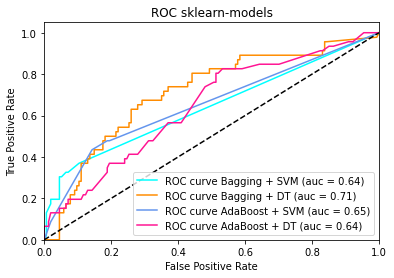

In [111]:
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue","deeppink"])
models = cycle(["Bagging + SVM","Bagging + DT","AdaBoost + SVM","AdaBoost + DT"])
for i, color,model in zip(range(4), colors, models):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve {0} (auc = {1:0.2f})".format(model, roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC sklearn-models")
plt.legend(loc="lower right")
plt.show()

`predictions`

In [108]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test, predictions[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

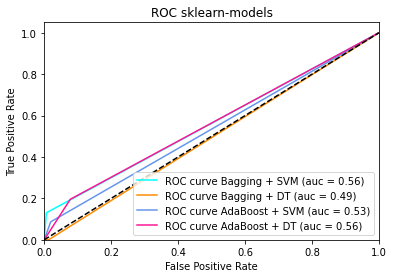

In [109]:
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue","deeppink"])
models = cycle(["Bagging + SVM","Bagging + DT","AdaBoost + SVM","AdaBoost + DT"])
for i, color,model in zip(range(4), colors, models):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve {0} (auc = {1:0.2f})".format(model, roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC sklearn-models")
plt.legend(loc="lower right")
plt.show()

### ***Self-models***

In [106]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test, predictions_self[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

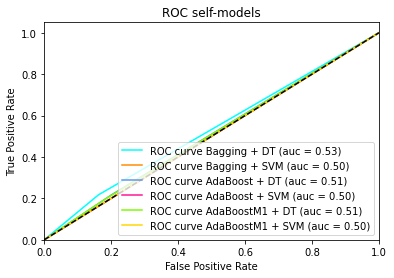

In [107]:
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue","deeppink","lawngreen","gold"])
models = cycle(["Bagging + DT","Bagging + SVM","AdaBoost + DT","AdaBoost + SVM","AdaBoostM1 + DT","AdaBoostM1 + SVM"])
for i, color,model in zip(range(6), colors, models):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve {0} (auc = {1:0.2f})".format(model, roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC self-models")
plt.legend(loc="lower right")
plt.show()